# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student.

In [ ]:

# Naor S 0270
# Dan K 0542
# Ofir A 4088
# Asaf D 6576

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:chatgpt
Goal: help with new algorithms
Propmpt1: Give me new learning algorithms that can help me with the Titanic dataset.
    
Propmpt2:
    
Propmpt3:


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3:

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

The dataset describes information about passengers aboard the Titanic. The task is to predict whether a passenger survived the disaster based on features such as gender, age, ticket class, and more.

This is a **binary classification problem**, where the target variable `Survived` is either 0 (did not survive) or 1 (survived). The learning process is supervised, meaning we train the model on labeled examples and then evaluate its ability to predict unseen cases.

We will walk through all steps of the supervised learning flow: from data loading and EDA, through feature engineering and model selection, to final evaluation.

## Part 2 - Initial Preparations
You could add as many code cells as needed

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer


# קריאת קבצים
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# הצגת השורות הראשונות
print("Train set:")
display(train.head())

print("Test set:")
display(test.head())

Train set:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


Test set:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


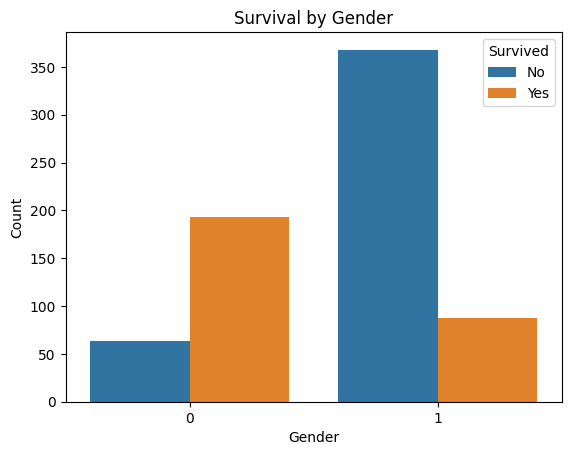

In [ ]:
#### Survival by Gender
# This visualization shows the number of passengers who survived vs. did not survive, grouped by gender.

# Insight:
# A significantly higher proportion of women survived compared to men. This supports the known historical context of "women and children first".

sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Survival by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

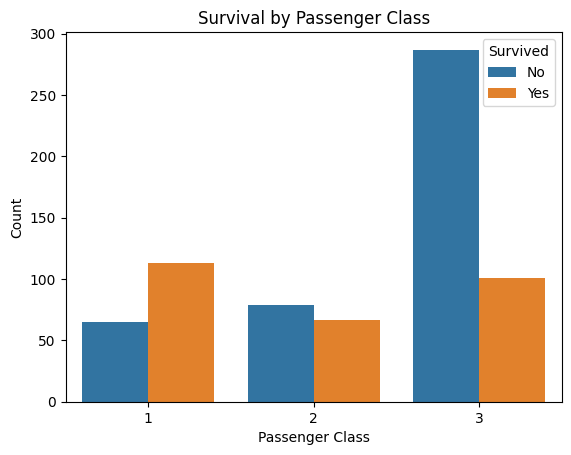

In [ ]:
#### Survival by Passenger Class
# This plot shows how passenger class (1st, 2nd, 3rd) affected survival rates.

# Insight:
# Passengers in 1st class had significantly higher survival rates, while those in 3rd class had the lowest.

sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

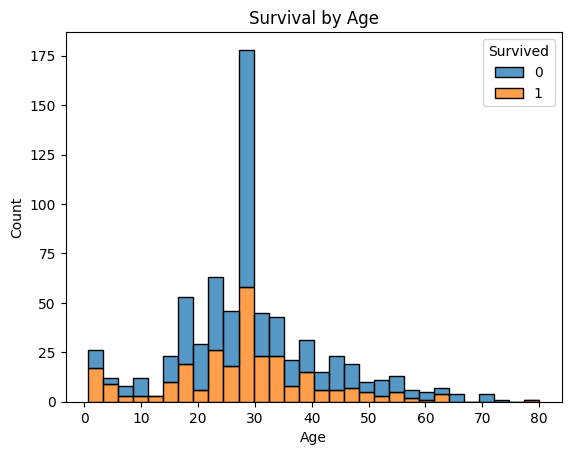

In [ ]:
#### Survival by Age
# This histogram shows the age distribution of survivors vs. non-survivors.

# Insight:
# We can observe a relatively high survival rate among young children, while survival drops for some adult age ranges.

sns.histplot(data=train, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Survival by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

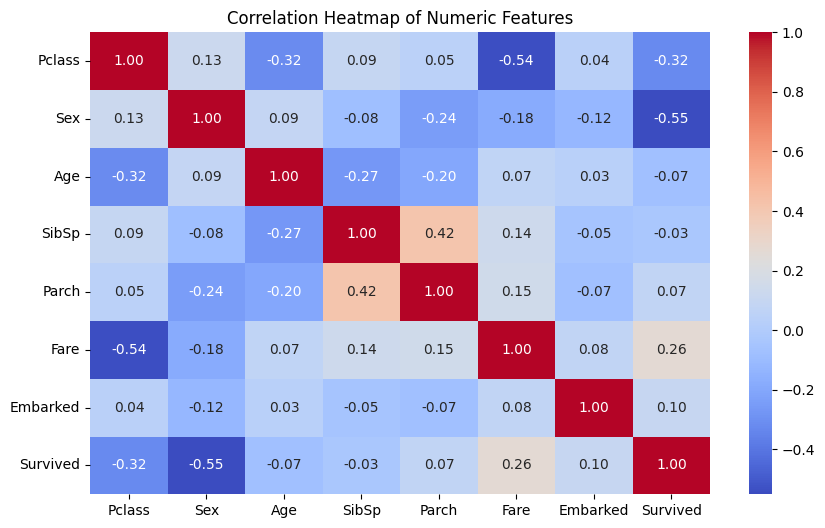

In [ ]:
#### Correlation Heatmap
# This heatmap shows the correlation between all numeric features.

# Insight:
# We can observe that:
# - `Fare` and `Pclass` have moderate correlation with `Survived`
# - `SibSp` and `Parch` are correlated with each other (both represent family size)
# - `Age` is weakly correlated, but still informative

# This helps guide our Feature Engineering: we may want to combine `SibSp` + `Parch`, or try new features based on these.


# נבחר רק עמודות מספריות
numeric_cols = train.select_dtypes(include=[np.number])

# מחשבים מטריצת קורלציה
corr = numeric_cols.corr()

# מציגים Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()



## Part 3 - Experiments
You could add as many code cells as needed

In [ ]:
# Feature Engineering
# We handled missing values by replacing:
# - `Age` with the mean
# - `Embarked` with the mode
# - `Fare` (in test set) with the mean
#
# We also encoded categorical features:
# - `Sex` and `Embarked` were mapped to integers.
#
# Additionally, we created new features:
# - `FamilySize` = SibSp + Parch + 1
# - `FarePerPerson` = Fare divided by family size
#
# These transformations provide the model with clearer signals and may improve prediction performance.


In [ ]:
# המרת מגדר – male=0, female=1
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# המרת נמל – משתמשים ב-one-hot או קידוד פשוט
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
train['Embarked'] = train['Embarked'].map(embarked_map)
test['Embarked'] = test['Embarked'].map(embarked_map)

In [ ]:
# גיל – נמלא את הערכים החסרים בגיל הממוצע
# גיל – נמלא את הערכים החסרים בגיל הממוצע
train.loc[:, 'Age'] = train['Age'].fillna(train['Age'].mean())
test.loc[:, 'Age'] = test['Age'].fillna(train['Age'].mean())

# נמל העלייה – נמלא לפי השכיח
train.loc[:, 'Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test.loc[:, 'Embarked'] = test['Embarked'].fillna(train['Embarked'].mode()[0])

# תשלום – אם יש חוסרים ב-Fare (רק ב-test)
test.loc[:, 'Fare'] = test['Fare'].fillna(train['Fare'].mean())

In [ ]:
# גודל משפחה = אחים/בני זוג + הורים/ילדים + 1 (הנוסע עצמו)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Fare per person – מחיר הכרטיס חלקי מספר האנשים
train['FarePerPerson'] = train['Fare'] / train['FamilySize']
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

In [ ]:
### Grid Search with Cross Validation

# We used 5-fold cross validation to evaluate two models: Logistic Regression and Random Forest.

# Each model was tested with multiple hyperparameter configurations using `GridSearchCV`, and evaluated based on `F1 Score (macro)` to account for class imbalance.

# Results:
# - Logistic Regression: Best F1 ≈ 0.76 with C=1
# - Random Forest: Best F1 ≈ 0.79 with 100 trees and max_depth=10

# We will now use the best-performing model (Random Forest) to retrain on the full dataset.

# הגדרת F1 macro כמדד

f1_macro = make_scorer(f1_score, average='macro')

train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['FarePerPerson'] = train['Fare'] / train['FamilySize']

test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

# פיצ'רים + עמודת מטרה
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'FarePerPerson']
X = train[features].copy()
y = train['Survived']

# טיפול ב-NAN
X = X.fillna(X.mean(numeric_only=True))

# Pipeline ללוגיסטית
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])
param_grid_log = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs']
}

# Pipeline לרנדום פורסט
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
param_grid_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5]
}

# הגדרת GridSearch
grid_log = GridSearchCV(pipe_log, param_grid_log, cv=5, scoring=f1_macro)
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring=f1_macro)

# הרצה
grid_log.fit(X, y)
grid_rf.fit(X, y)

# תוצאות
print("Best Logistic Regression:")
print(grid_log.best_params_)
print("Best F1 Score:", round(grid_log.best_score_, 3))

print("\nBest Random Forest:")
print(grid_rf.best_params_)
print("Best F1 Score:", round(grid_rf.best_score_,3))

Best Logistic Regression:
{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best F1 Score: 0.789

Best Random Forest:
{'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best F1 Score: 0.827


## Part 4 - Training
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [ ]:
# We retrain the best-performing model (Random Forest) using the full training dataset.
# The best configuration found via Grid Search is:
# - n_estimators = 100
# - max_depth = None
# - min_samples_split = 5

# Missing values were handled by imputing numeric features with their mean.
# This model will now be used to predict on the test set.

In [ ]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['FarePerPerson'] = train['Fare'] / train['FamilySize']

test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'FarePerPerson']
X = train[features].copy()
y = train['Survived']

# למקרה שיש NaNs – נמלא
X = X.fillna(X.mean(numeric_only=True))

# יצירת המודל הסופי עם הפרמטרים שנבחרו
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5
)

# אימון סופי על כל הדאטה
final_model.fit(X, y)

RandomForestClassifier(min_samples_split=5)

## Part 5 - Apply on test and show model performance estimation

In [ ]:
# נוודא שפיצ'רים קיימים ב-test
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

# אותם פיצ'רים כמו ב-train
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'FarePerPerson']
X_test = test[features].copy()

# טיפול ב-NAN אם יש
X_test = X_test.fillna(X_test.mean(numeric_only=True))

# תחזיות
y_pred = final_model.predict(X_test)

First 5 predictions: [0 0 0 1 1]
Accuracy on train: 0.9396067415730337
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       431
           1       0.95      0.90      0.92       281

    accuracy                           0.94       712
   macro avg       0.94      0.93      0.94       712
weighted avg       0.94      0.94      0.94       712



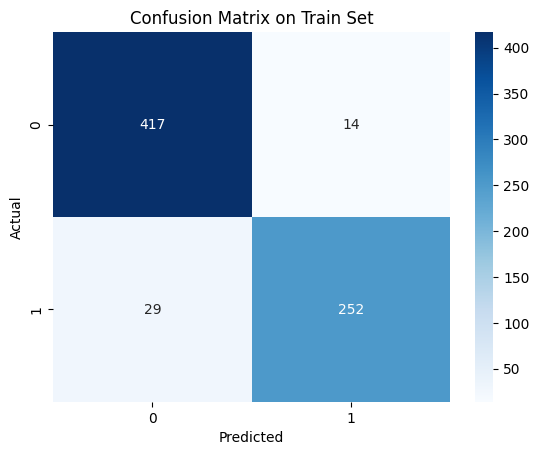

In [ ]:
print("First 5 predictions:", y_pred[:5])
y_train_pred = final_model.predict(X)

# דיוק
print("Accuracy on train:", accuracy_score(y, y_train_pred))

# דוח מלא
print(classification_report(y, y_train_pred))

# מטריצת בלבול
cm = confusion_matrix(y, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Train Set")
plt.show()